# Задача 2. Сравнение методов классификации
## Божнюк Александр Сергеевич, группа 19.Б11

### Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1]:
# Необходимые импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Реализация метода опорных векторов

In [2]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            condition = y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1
            if condition:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Реализация метода Naive Bayes

In [74]:
class NBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, priors=None, var_smoothing=1e-9):
        self.priors = priors
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self.epsilon = self.var_smoothing * np.var(X, axis=0).max()
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        if self.priors is None:
            self.priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0) + self.epsilon
            if self.priors[idx] == 0:
                self.priors[idx] = X_c.shape[0] / float(n_samples)
        return self

    def predict(self, X):
        y_pred = [self._predict_sample(x) for x in X]
        return np.array(y_pred)

    def _predict_sample(self, x):
        posts = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self.priors[idx])
            post = np.sum(np.log(self._gaussian_pdf(idx, x)))
            post = post + prior
            posts.append(post)
        return self._classes[np.argmax(posts)]

    def _gaussian_pdf(self, class_idx, x):
        mu = self._mean[class_idx, 0]
        sigma = self._var[class_idx, 0]
        return (np.exp(-((x - mu) ** 2) / (2 * sigma))) / (np.sqrt(2 * np.pi * sigma))

    def get_params(self, deep=True):
        return {"priors": self.priors, "var_smoothing": self.var_smoothing}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Датасет

In [4]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Описание датасета:

- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)
Необходимо решить задачу классификации и научиться предсказывать целевой признак target имеет ли пациент заболевание сердца.

# EDA

In [5]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Видим, что датасет сбалансирован, у целевого признака примерно одинаковое количество значений как для 1, так и для 0.
Можем отобразить это на диаграмме:

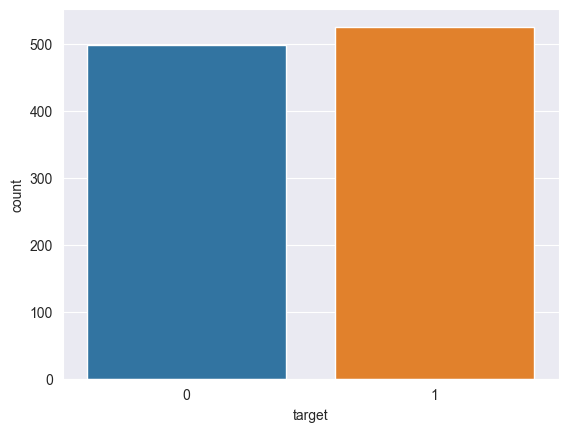

In [6]:
sns.countplot(x="target", data=df)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Видим, что нет null значений, 13 признаков у нас целые, и 1 с плавающей точкой.

Посмотрим на диаграмму наличия сердечного признака в зависимости от возраста.

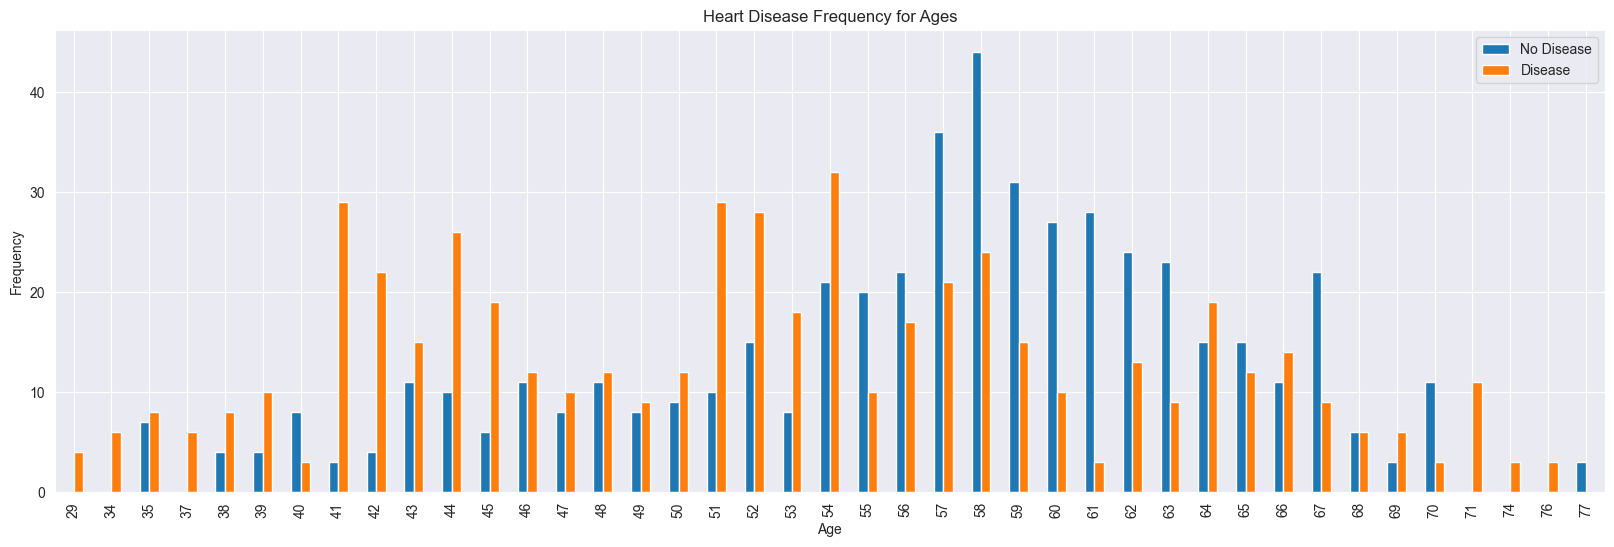

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

Видим, что больше всего переживают приступы в возрасте от 41-45 и 51-54, в то время люди без приступов в большинстве своем находятся на промежутке от 55-63 лет.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и уровня холестерина.

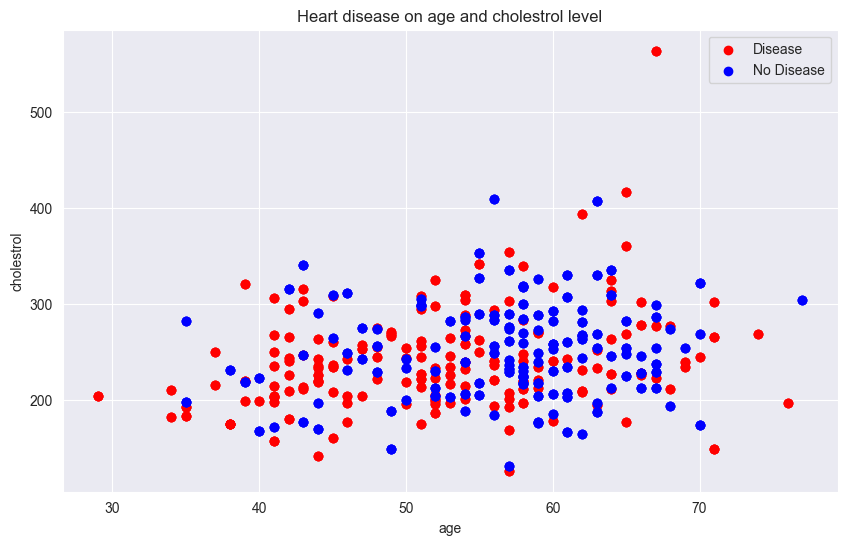

In [9]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.chol[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.chol[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and cholestrol level")
plt.xticks(rotation = 0);

Видим, что люди от 41-45 и 51-54 имеют уровень холестерина меньше, чем у людей от 55-63 лет. У первых количество сердечных приступов меньше, чем у вторых.

Построим диаграмму количества сердечных приступов в зависимости от пола.

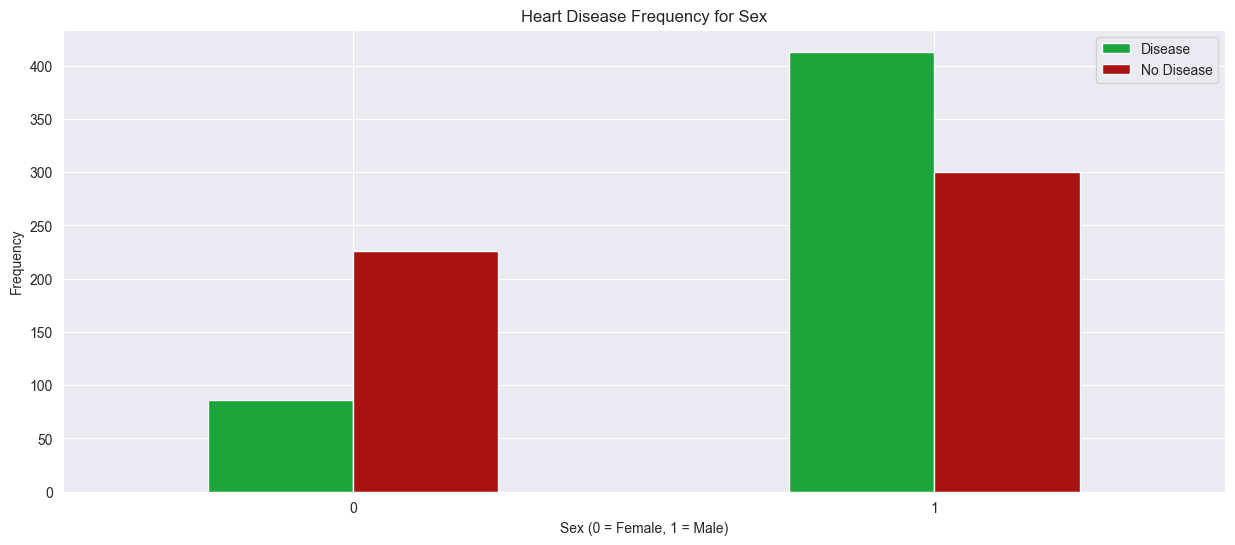

In [10]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Disease", "No Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что в большинстве своем с сердечным приступом сталкиваются мужчины.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и от максимальной частоты сердечных сокращений.

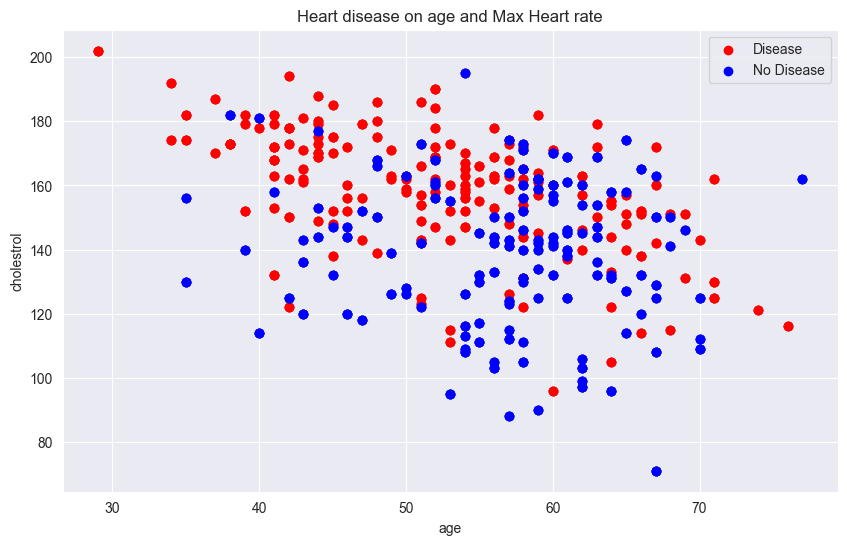

In [11]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.thalach[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and Max Heart rate")
plt.xticks(rotation = 0);

Видим, что частота сокращений у людей проблемного возраста выше. У них же и наблюдается больше всего сердечных приступов. Напротив, у людей с меньшей частотой сокращений наблюдается меньше сердечных приступов, и они находятся как раз в том, возрасте, что мы наблюдали ранее.

Посмотрим на то, как меняется количество сердечных приступов в зависимости от типа боли в груди.

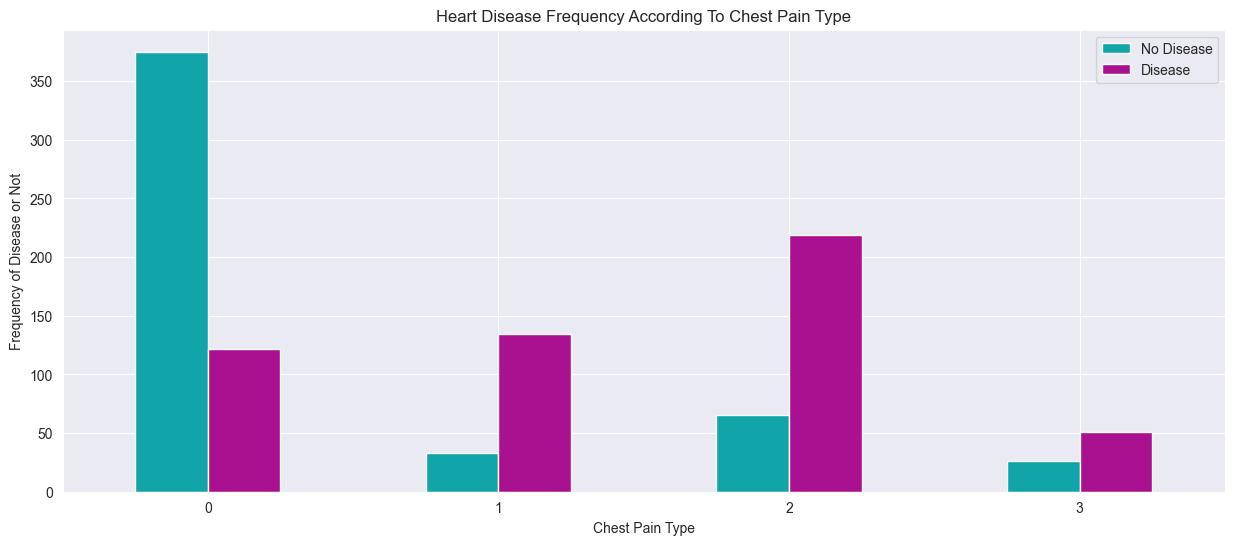

In [12]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15,6),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видно, что большинство пострадавших сталкивались с болью типа 2, меньше всего сталкивались с типом 3. Большинство избежавших приступа сталкивались с болью типа 0, а меньше всего - с типом 3.

Посмотрим на количество приступов в зависимости от пика физической нагрузки

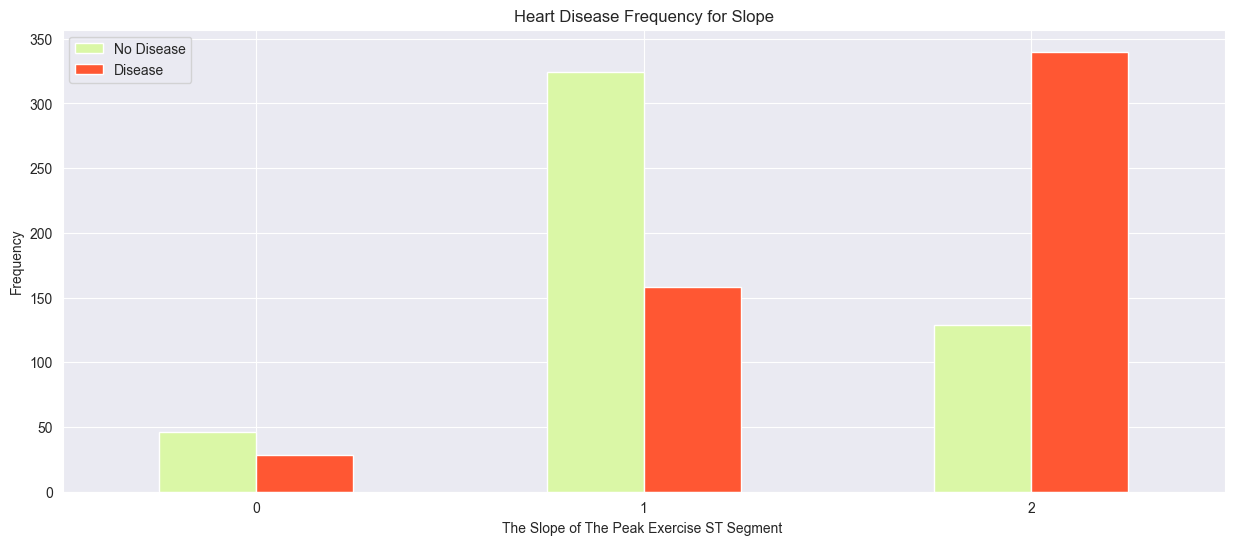

In [13]:
pd.crosstab(df.slope,df.target).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что большинство пострадавших находятся в типе 2, а большинство переживших - в типе 1. В тип 0 не попало меньше всего людей.

Посмотрим на количество приступов в зависимости от количества сахара в крови во время голодания.

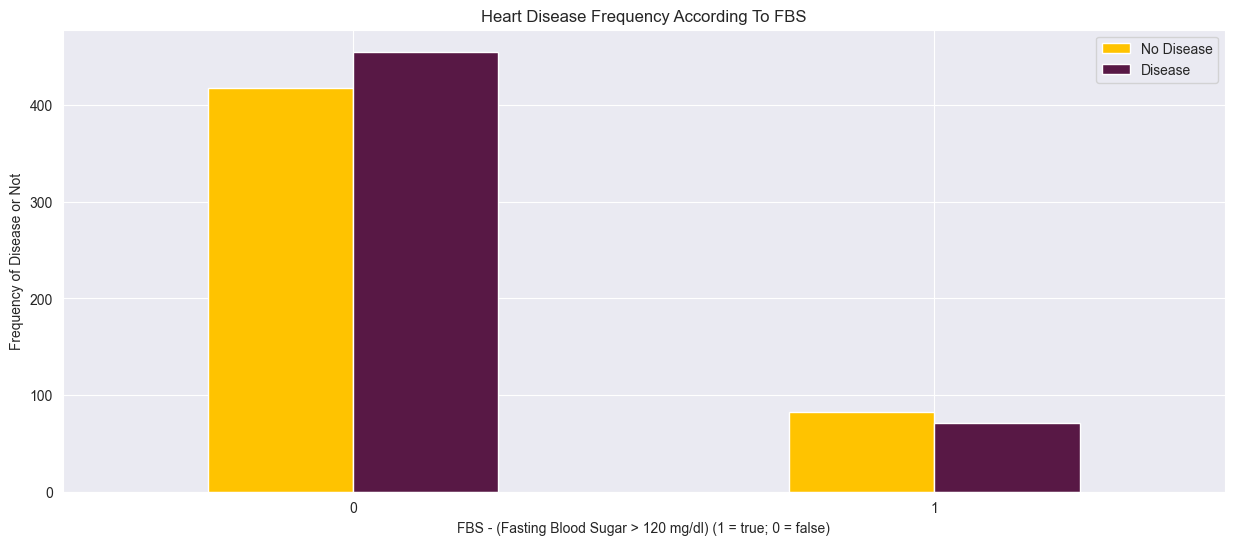

In [14]:
pd.crosstab(df.fbs,df.target).plot(kind="bar",figsize=(15,6),color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видим, большинство людей, которые пережили приступ, имели пониженный сахар. Однако большинство людей в принципе (и среди тех, кто не пережл приступ) в выборке имели пониженный сахар.

Посмотрим на корреляцию признаков нашего датасета

<AxesSubplot: >

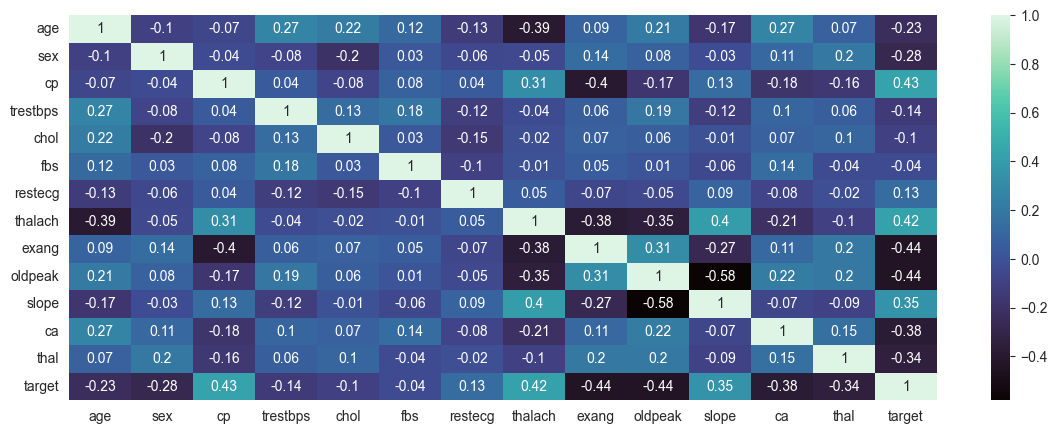

In [15]:
plt.figure(figsize = (14,5))
sns.heatmap(round(df.corr(),2),annot=True,cmap = 'mako')

Видно, что наибольшая корреляция признака target наблюдается с признаком slope, thalach и cp

# Feature Engineering

## Преобразование категориальных данных
Преобразуем категориальные признаки, закодировав их.

In [16]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


## Разделение выборки

In [17]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Масштабирование

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,-0.585840,0.654654,-0.779454,-1.935031,-0.414039,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
1,1.051477,-1.527525,2.741732,1.610634,-0.414039,0.909846,0.202882,1.377507,-0.912152,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
2,-0.040068,-1.527525,-1.347387,0.442176,-0.414039,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
3,0.505705,0.654654,0.186033,-0.222636,-0.414039,0.909846,0.508376,-0.725949,-0.473720,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,-0.265511,1.042360,-0.913483
4,-0.367531,0.654654,-0.381900,-0.001032,2.415229,-0.983742,0.726586,-0.725949,1.192321,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,1.042360,-0.913483


## Подбор наилучших признаков

In [19]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  17
Выбранные признаки:  ['sex', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


 Избавимся от ненужных признаков

In [20]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,sex,trestbps,chol,restecg,thalach,exang,oldpeak,ca,cp_0,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_1,slope_2
0,0.654654,-0.779454,-1.935031,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
1,-1.527525,2.741732,1.610634,0.909846,0.202882,1.377507,-0.912152,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
2,-1.527525,-1.347387,0.442176,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
3,0.654654,0.186033,-0.222636,0.909846,0.508376,-0.725949,-0.473720,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,1.042360,-0.913483
4,0.654654,-0.381900,-0.001032,-0.983742,0.726586,-0.725949,1.192321,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,1.042360,-0.913483


# Подбор гиперпараметров

## SVMClassifier - моя реализация

In [860]:
learning_rate_grid = [0.1, 0.001, 0.0001]
iter_num_grid = [100, 1000, 5000, 10000]
lmda_grid = [0.1, 0.001, 0.0001]

cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMClassifier(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lmda": lmda_grid}],
                        cv=cv, verbose=5)
_ = searcher.fit(x_train_scaled, y_train)

optimal_learning_rate = searcher.best_params_["learning_rate"]
print("Best learning_rate = %.4f:", optimal_learning_rate)

optimal_iter_num = searcher.best_params_["iter_num"]
print("Best iter_num = %.4f", optimal_iter_num)

optimal_lmda = searcher.best_params_["lmda"]
print("Best lmda = %.4f", optimal_lmda)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.799 total time=   0.6s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.835 total time=   0.8s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.811 total time=   0.5s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.848 total time=   0.5s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.744 total time=   0.5s
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.835 total time=   0.5s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.829 total time=   0.5s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.841 total time=   0.5s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.866 total time=   0.5s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.750 total time=   0.5s
[CV 1/5] END iter_num=100, learning_rate=0.1, lm

## NBClassifier - моя реализация

In [75]:
priors_grid = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing_grid = np.logspace(0, -9, num=100)

nb = NBClassifier()
cv = StratifiedKFold(5)

searcher = GridSearchCV(nb,
                        [{"priors": priors_grid, "var_smoothing": var_smoothing_grid}],
                        cv=cv)
searcher.fit(x_train_scaled.to_numpy(), y_train.to_numpy())

print("best estimator: " + str(searcher.best_estimator_))
print("best params: " + str(searcher.best_params_))
print('best score:', searcher.best_score_)

best estimator: NBClassifier(priors=array([0.48414634, 0.51585366]),
             var_smoothing=0.15199110829529336)
best params: {'priors': None, 'var_smoothing': 0.15199110829529336}
best score: 0.671951219512195


## LogisticRegression библиотечный

In [847]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(x_train_scaled, y_train)
results = gs.cv_results_

print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

best estimator: LogisticRegression(C=0.60001)
best params: {'C': 0.60001}
best score: 0.8695121951219512


## SVM библиотечный

In [848]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv,
                        param_grid=dict(kernel=kernel,C=C, gamma=gamma))
grid_svm.fit(x_train_scaled, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)
print("test score:", grid_svm.score(x_test_scaled, y_test))

best score:  0.9756097560975612
best param:  {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
test score: 0.9853658536585366


## KNN библиотечный

In [853]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

knn = KNeighborsClassifier()
std_scale = StandardScaler()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12)

knn_clf = GridSearchCV(estimator=knn, cv=rskfold,
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy')

knn_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(knn_clf.best_estimator_))
print("best params: " + str(knn_clf.best_params_))
print('best score:', knn_clf.best_score_)

best estimator: KNeighborsClassifier(n_neighbors=7, weights='distance')
best params: {'n_neighbors': 7, 'weights': 'distance'}
best score: 0.9804878048780487


## Naive Bayes библиотечный

In [25]:
priors = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

nb = GaussianNB()
n_folds=5
n_repeats=5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=23)

nb_clf = GridSearchCV(estimator=nb, cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')

nb_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(nb_clf.best_estimator_))
print("best params: " + str(nb_clf.best_params_))
print('best score:', nb_clf.best_score_)

best estimator: GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
best params: {'priors': [0.62, 0.38], 'var_smoothing': 0.657933224657568}
best score: 0.8558536585365855


## Decision Tree библиотечный

In [854]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv,
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features))
grid_dt.fit(x_train_scaled, y_train)
print("best score: ", grid_dt.best_score_)
print("best param: ", grid_dt.best_params_)
print("test score:", grid_dt.score(x_test_scaled, y_test))

best score:  0.9902439024390244
best param:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
test score: 1.0


# Тестирование моделей

Запустим необходимые модели с подстановкой подобранных гиперпараметров

In [88]:
accuracies = {}

## SVMClassifier - моя реализация

In [89]:
classifier = SVMClassifier(learning_rate=0.001, iter_num=100, lmda=0.001)
classifier.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = classifier.predict(x_test_scaled)
acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8146


## NBClassifier - моя реализация

In [90]:
my_nb = NBClassifier(priors=None, var_smoothing=0.15199110829529336)
my_nb.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = my_nb.predict(x_test_scaled.to_numpy())

acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_NB'] = acc
print("Test Accuracy of My Naive Bayes Algorithm: {:.4f}".format(acc))

Test Accuracy of My Naive Bayes Algorithm: 0.6000


## LogisticRegression библиотечный

In [91]:
lr = LogisticRegression(C=0.60001)
lr.fit(x_train_scaled, y_train)
acc = lr.score(x_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.8049


## SVM библиотечный

In [92]:
svm = SVC(C=0.5, gamma=1, kernel='rbf', random_state = 11)
svm.fit(x_train_scaled, y_train)

acc = svm.score(x_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9854


## KNN библиотечный

In [93]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(x_train_scaled, y_train)

acc = knn.score(x_test_scaled, y_test)
accuracies['KNN'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9854


## Naive Bayes библиотечный

In [94]:
nb = GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
nb.fit(x_train_scaled, y_train)

acc = nb.score(x_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8098


## Decision Tree библиотечный

In [104]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, splitter='best')
dtc.fit(x_train, y_train)

acc = dtc.score(x_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9707


## Сравнение моделей

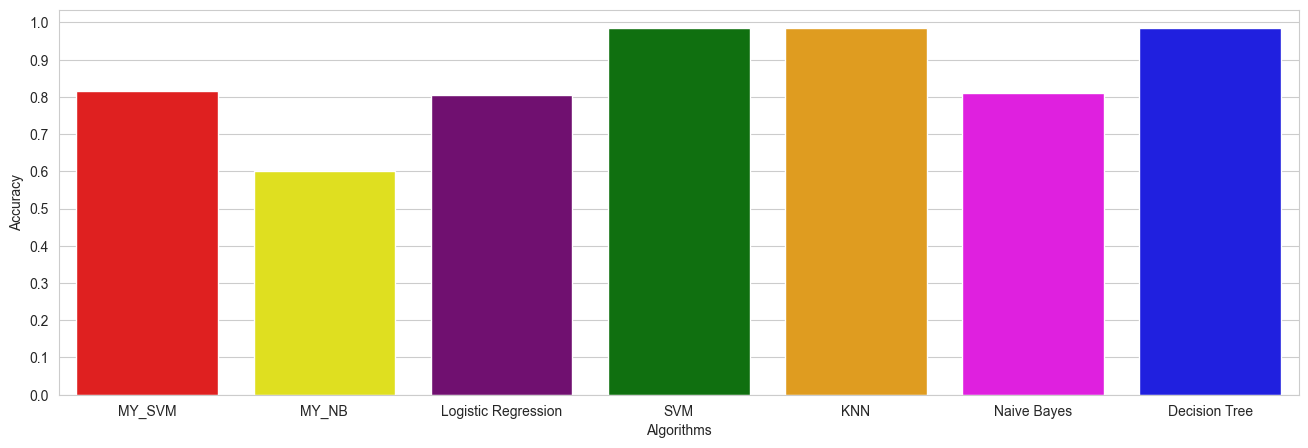

In [96]:
colors = ["red", "yellow", "purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

# Confusion Matrix

In [100]:
y_pred_my_svm = classifier.predict(x_test_scaled)
y_pred_my_nb = my_nb.predict(x_test_scaled.to_numpy())
y_pred_lr = lr.predict(x_test_scaled)
y_pred_knn = knn.predict(x_test_scaled)
y_pred_svm = svm.predict(x_test_scaled)
y_pred_nb = nb.predict(x_test_scaled)
y_pred_dtc = dtc.predict(x_test_scaled)

cm_my_svm = confusion_matrix(y_test, y_pred_my_svm)
cv_my_nb = confusion_matrix(y_test, y_pred_my_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_dt = confusion_matrix(y_test, y_pred_dtc)

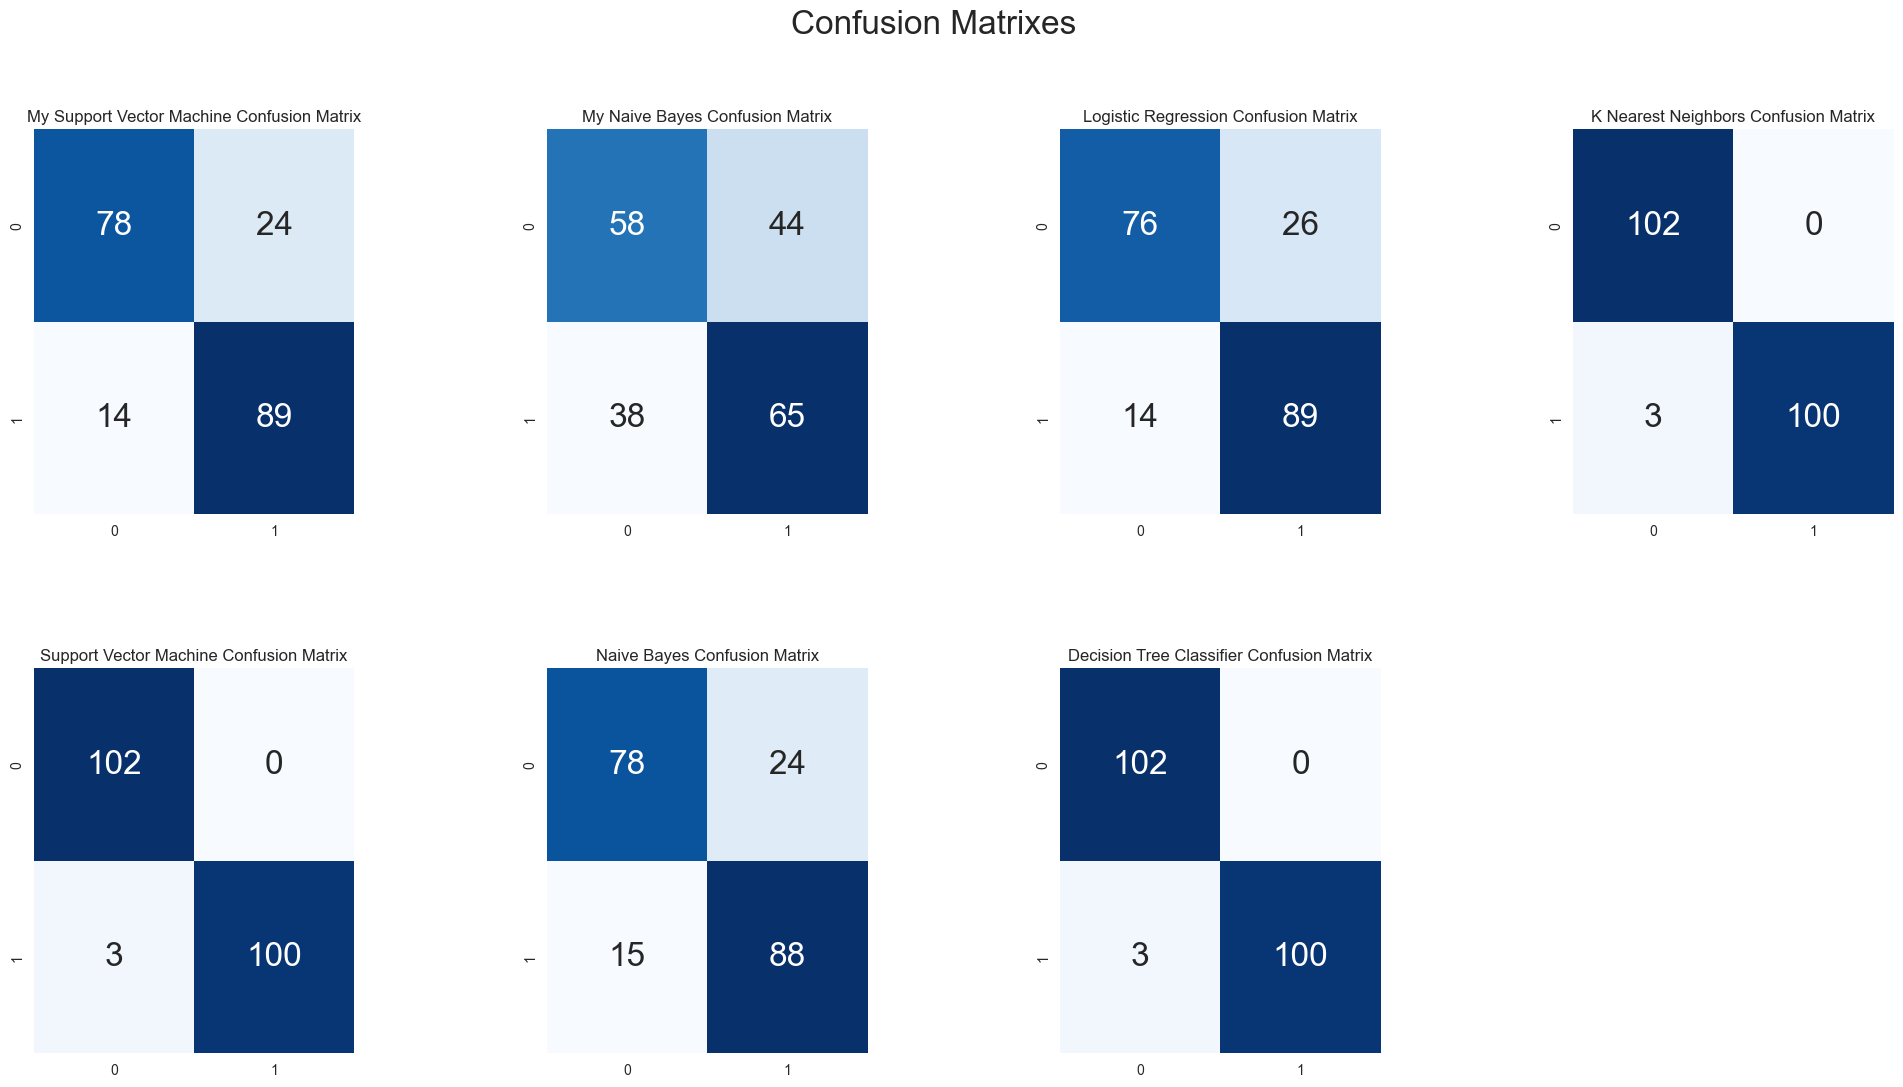

In [102]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("My Support Vector Machine Confusion Matrix")
sns.heatmap(cm_my_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("My Naive Bayes Confusion Matrix")
sns.heatmap(cv_my_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы по первому датасету

- Моя реализация SVM по качеству почти не отличается от библиотечной SVM и не хуже других методов
- Моя реализация Naive Bayes показывает результаты лучше среднего, но хуже остальных параметров, хоть и с подбором параметров и кросс-валидацией
- Лучше всего себя показала Decision Tree
- Хуже всего себя показала Логистическая регрессия, но она не сильно отстает от библиотечной Naive Bayes